# LAB | Random Forests

### Instructions

- Apply the Random Forests algorithm but this time only by upscaling the data to deal with the imbalance.
- Use Feature Selections that you have learned in class to decide if you want to use all of the features (Variance Threshold, RFE, PCA, etc.)
- Re-run the Random Forest algorithm to determine if the Feature Selection has improved the results.
- Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

In [77]:
# import libraries 
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [78]:
#pip install mlxtend # for confusion matrix visuals

In [79]:
# import files 
numerical = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_pickle('files_for_lab/categorical.pkl')
target = pd.read_csv('files_for_lab/target.csv')

categorical = categorical.astype(str)


In [80]:
# confirm no nans present
numerical.isna().sum().sum()
target.isna().sum().sum()
categorical.isna().sum().sum()

0

In [81]:
# x-y split
X = pd.concat([numerical, categorical], axis = 1)
y = target['TARGET_B']

In [82]:
# train-test split before upsampling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numX_train = X_train.select_dtypes(np.number)
numX_test = X_test.select_dtypes(np.number)
catX_train = X_train.select_dtypes(object) 
catX_test = X_test.select_dtypes(object) 

In [83]:
# onehotencode catgs
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(catX_train)
cat_train_enconded = encoder.transform(catX_train).toarray()
cat_train_enconded = pd.DataFrame(cat_train_enconded, columns=encoder.get_feature_names_out()) 
cat_test_enconded = encoder.transform(catX_test).toarray()
cat_test_enconded = pd.DataFrame(cat_test_enconded, columns=encoder.get_feature_names_out())

In [84]:
# scale numericals
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(numX_train)
num_train_scaled = transformer.transform(numX_train)
num_train_scaled = pd.DataFrame(num_train_scaled, columns=numX_train.columns)
num_test_scaled  = transformer.transform(numX_test)
num_test_scaled  = pd.DataFrame(num_test_scaled, columns=numX_train.columns)

In [85]:
# concat trains and tests
X_train_treated = pd.concat([num_train_scaled, cat_train_enconded], axis = 1)
X_test_treated  = pd.concat([num_test_scaled, cat_test_enconded],  axis = 1)

In [86]:
# upsampling 
# concat train x and y temporarily, remember to reset index on y train
sample_train = pd.concat([X_train_treated, y_train.reset_index(drop=True)], axis=1)

yes_donate = sample_train[sample_train['TARGET_B']==1]
no_donate = sample_train[sample_train['TARGET_B']==0]

from sklearn.utils import resample
yes_donate_oversampled = resample(yes_donate, 
                                replace=True,
                                n_samples = len(no_donate),
                                random_state=0)

oversampled = pd.concat([yes_donate_oversampled, no_donate], axis=0)
oversampled = oversampled.sample(frac=1)

In [87]:
print(no_donate.shape)
print(yes_donate_oversampled.shape)
print(oversampled.shape)

(72486, 407)
(72486, 407)
(144972, 407)


In [88]:
X_train_oversampled = oversampled.drop(['TARGET_B'], axis = 1)
y_train_oversampled = oversampled['TARGET_B']

In [89]:
# build random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                            min_samples_split=20, # amount of rows still considered at every question
                            min_samples_leaf =20, # ultimate answer based on at least this many rows
                            #max_samples=0.8, #   as we're already giving it samples
                            random_state=42)
# fit the classifier
clf.fit(X_train_oversampled, y_train_oversampled)

# print scores
print(clf.score(X_train_oversampled, y_train_oversampled))
print(clf.score(X_test_treated, y_test))

y_pred = clf.predict(X_test_treated)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.6229340838230831
0.6105434156055127


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[11116,  6967],
       [  465,   535]])

In [90]:
# get the cross validation score from this model
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=5,
                            min_samples_split=20,
                            min_samples_leaf =20,
                            # max_samples=0.8 # default val is 1, wwhich means we use 100% of all vals
                            )
cross_val_scores = cross_val_score(clf, X_train_oversampled, y_train_oversampled, cv=10, scoring='f1')
# we build 10 random classifiers, and each one has 100 trees 
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.6223034229849286
[0.61440504 0.61477859 0.61409879 0.6174515  0.62883645 0.61069431
 0.63178004 0.63483871 0.62626263 0.62988817]


***

##### Feat selection: Variance Threshold

We will first try our dataset with variance threshold and see how a model works with just that feature selection. We will compare later with another method stacked on the result from this one.

In [91]:
# feature selection
# variance threshold
from sklearn.preprocessing import MinMaxScaler
var_scaler = MinMaxScaler()
numerical_scaled = var_scaler.fit_transform(numerical)

from sklearn.feature_selection import VarianceThreshold  
sel = VarianceThreshold(threshold=0.02)

# fit threshold to drop cols lower than this
sel = sel.fit(numerical_scaled)

In [92]:
# check cols with low variance
num_variance_transform = sel.transform(numerical_scaled)
low_var_cols = list(sel.get_support())

# use list above to drop 
drop_list = [col[0] for col in zip(numerical.columns, low_var_cols) if col[1] == False]
col_list = [col[0] for col in zip(numerical.columns, low_var_cols) if col[1] == True]

num_post_variance = pd.DataFrame(sel.transform(numerical_scaled), columns = col_list)
num_post_variance.shape
type(drop_list)

list

In [118]:
# drop cols with high corr with each other
corr_matrix = num_post_variance.corr()

def high_corr(matrix):
    highly_corr=pd.DataFrame()
    
    for col in matrix.columns:
        correlated_cols = matrix[(abs(matrix[col]) >= 0.9)].index   
        correlated_pairs = pd.DataFrame({'Column 1': col, 'Column 2': correlated_cols})  
        highly_corr = pd.concat([highly_corr, correlated_pairs], ignore_index=True)
    highly_corr = highly_corr[highly_corr['Column 1'] < highly_corr['Column 2']]    
    return highly_corr
high_corr(corr_matrix)

,Column 1,Column 2
13,DW1,DW2
17,DW4,DW5
18,DW4,DW6
21,DW5,DW6
22,DW5,HUPA2
23,DW5,HUPA6
27,DW6,HUPA2
28,DW6,HUPA6
30,HV1,HV2
31,HV1,HVP1


In [140]:
# turn res of 2nd col into a list wihout duplicates to drop em from num
col2_to_drop = list(high_corr(corr_matrix)['Column 2'])

drop_list = list(dict.fromkeys(col2_to_drop))
num_post_var_corr = num_post_variance.drop(drop_list, axis=1)
num_post_var_corr.shape

(95412, 60)

In [125]:
# try a model with just using variance feat selection
numerical_postvar = numerical.drop(drop_list, axis=1)
X = pd.concat([numerical_postvar, categorical], axis = 1)
y = target['TARGET_B']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numX_train = X_train.select_dtypes(np.number)
numX_test = X_test.select_dtypes(np.number)
catX_train = X_train.select_dtypes(object) 
catX_test = X_test.select_dtypes(object) 

# onehotencode catgs
encoder = OneHotEncoder(drop='first').fit(catX_train)
cat_train_enconded = encoder.transform(catX_train).toarray()
cat_train_enconded = pd.DataFrame(cat_train_enconded, columns=encoder.get_feature_names_out()) 
cat_test_enconded = encoder.transform(catX_test).toarray()
cat_test_enconded = pd.DataFrame(cat_test_enconded, columns=encoder.get_feature_names_out())

# scale numericals
transformer = MinMaxScaler().fit(numX_train)
num_train_scaled = transformer.transform(numX_train)
num_train_scaled = pd.DataFrame(num_train_scaled, columns=numX_train.columns)
num_test_scaled  = transformer.transform(numX_test)
num_test_scaled  = pd.DataFrame(num_test_scaled, columns=numX_train.columns)

# concat trains and tests
X_train_treated_vr = pd.concat([num_train_scaled, cat_train_enconded], axis = 1)
X_test_treated_vr  = pd.concat([num_test_scaled, cat_test_enconded],  axis = 1)

In [126]:
# upsampling 
# concat train x and y temporarily, remember to reset index on y train
sample_train = pd.concat([X_train_treated_vr, y_train.reset_index(drop=True)], axis=1)

yes_donate = sample_train[sample_train['TARGET_B']==1]
no_donate = sample_train[sample_train['TARGET_B']==0]

yes_donate_oversampled = resample(yes_donate, 
                                replace=True,
                                n_samples = len(no_donate),
                                random_state=0)

oversampled = pd.concat([yes_donate_oversampled, no_donate], axis=0)
oversampled = oversampled.sample(frac=1)

X_train_oversampled_vr = oversampled.drop(['TARGET_B'], axis = 1)
y_train_oversampled_vr = oversampled['TARGET_B']

In [127]:
# get the cross validation score from this model with the highest variance 
clf = RandomForestClassifier(max_depth=5,
                            min_samples_split=20,
                            min_samples_leaf =20,
                            # max_samples=0.8 # default val is 1, wwhich means we use 100% of all vals
                            )
cross_val_scores = cross_val_score(clf, X_train_oversampled_vr, y_train_oversampled_vr, cv=10, scoring='f1')
# we build 10 random classifiers, and each one has 100 trees 
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.6197159955938285
[0.62267985 0.62727335 0.62035011 0.63083356 0.60864714 0.61620513
 0.61568976 0.61981441 0.61790497 0.61776167]


In [128]:
# build random forest classifier for var treated data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                            min_samples_split=20, # amount of rows still considered at every question
                            min_samples_leaf =20, # ultimate answer based on at least this many rows
                            #max_samples=0.8, #   as we're already giving it samples
                            random_state=42)
# fit the classifier
clf.fit(X_train_oversampled_vr, y_train_oversampled_vr)

# print scores
print(clf.score(X_train_oversampled_vr, y_train_oversampled_vr))
print(clf.score(X_test_treated_vr, y_test))

y_pred = clf.predict(X_test_treated_vr)
display(y_test.value_counts())

0.6222098060315095
0.6145260179217105


0    18083
1     1000
Name: TARGET_B, dtype: int64

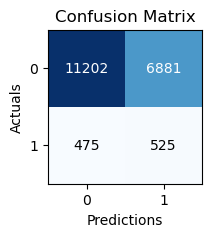

In [129]:
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,figsize=(2, 2), cmap=plt.cm.Blues)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

***

##### Feat selection: RFE

In [135]:
# RFE
X = num_post_var_corr
y = target['TARGET_B']

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
rfe = RFE(LR, n_features_to_select=25, verbose=False)
rfe.fit(X, y)

/Users/valgz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/valgz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

RFE(estimator=LogisticRegression(), n_features_to_select=25, verbose=False)

In [141]:
# After we run the algorithm, it labels the top features as 1 and the rest are marked in an increasing order of importance.
df = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df['Column_name'] = pd.DataFrame(num_post_var_corr).columns
ranking = df[df['Rank']==1]
ranking

,Rank,Column_name
1,1,INCOME
9,1,ETH1
11,1,HHN3
12,1,DW1
14,1,HV1
15,1,HV3
16,1,HU1
18,1,HHD2
19,1,ETHC2
22,1,HUR2


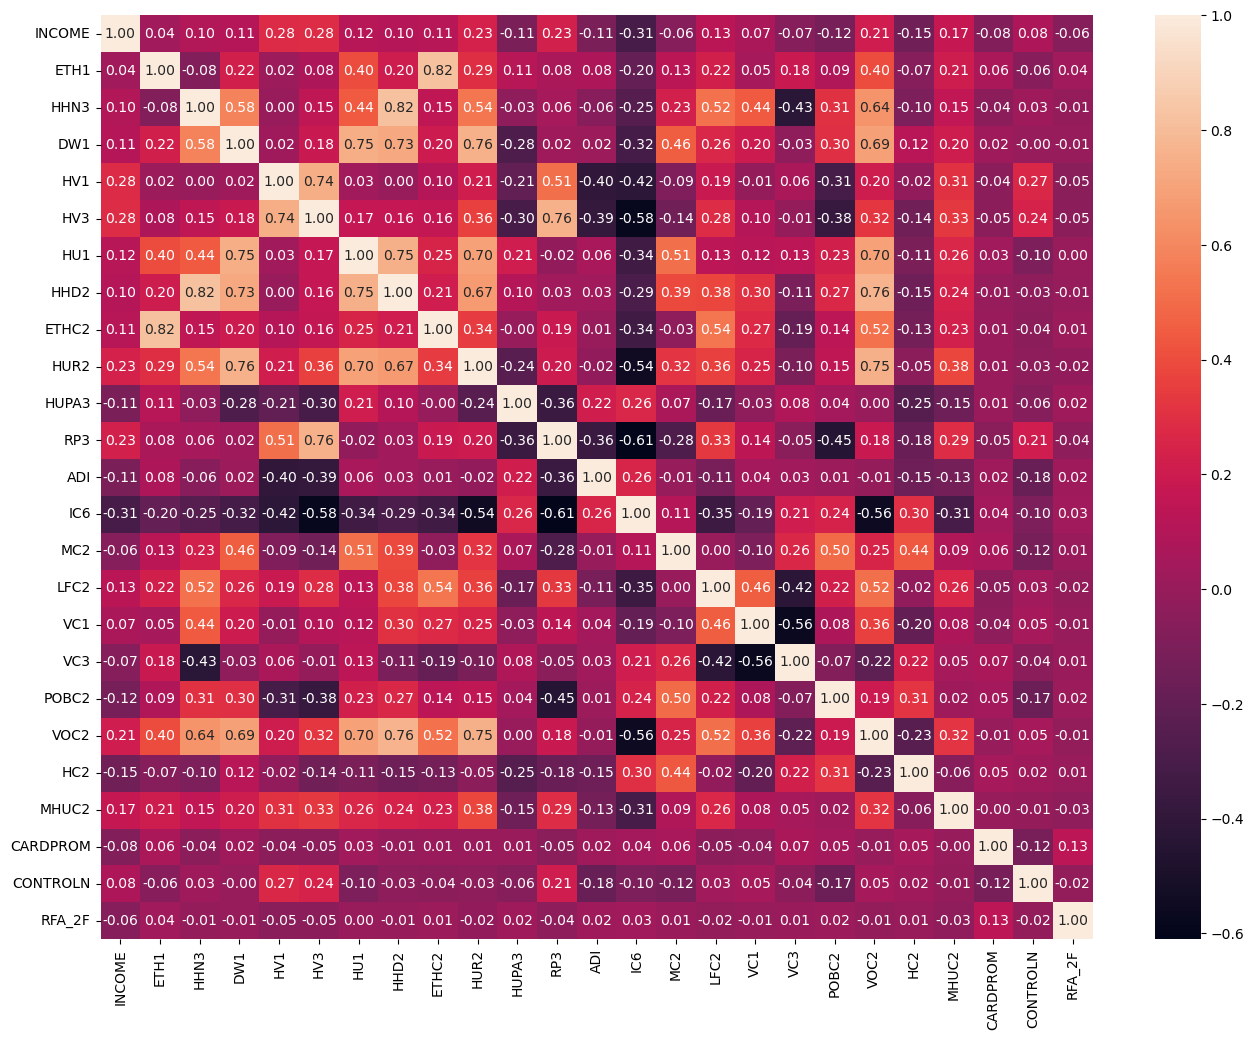

In [142]:
# check corr after rfe to see if they are too related between e/o
import matplotlib.pyplot as plt
import seaborn as sns

ranking_corr = num_post_var_corr[df[df['Rank']==1]['Column_name']].corr(method='pearson') #default
fig, ax= plt.subplots(figsize=(16,12))
sns.heatmap(ranking_corr, annot=True, fmt=".2f")
plt.show()

In [149]:
# no highly correlated with each other cols left to drop


# setting up ranking cols as the ones for our final numerical dataset
# support_ works similarly to varthresh get_support to know which cols are meeting the params

ranking_cols = num_post_var_corr.columns[rfe.support_]
num_post_featselect = num_post_var_corr[ranking_cols]
num_post_featselect.shape

(95412, 25)

In [150]:
# try a model with both using variance and rfe feat selection
numerical_postrfe = numerical[ranking_cols]
X = pd.concat([numerical_postrfe, categorical], axis = 1)
y = target['TARGET_B']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numX_train = X_train.select_dtypes(np.number)
numX_test = X_test.select_dtypes(np.number)
catX_train = X_train.select_dtypes(object) 
catX_test = X_test.select_dtypes(object) 

# onehotencode catgs
encoder = OneHotEncoder(drop='first').fit(catX_train)
cat_train_enconded = encoder.transform(catX_train).toarray()
cat_train_enconded = pd.DataFrame(cat_train_enconded, columns=encoder.get_feature_names_out()) 
cat_test_enconded = encoder.transform(catX_test).toarray()
cat_test_enconded = pd.DataFrame(cat_test_enconded, columns=encoder.get_feature_names_out())

# scale numericals
transformer = MinMaxScaler().fit(numX_train)
num_train_scaled = transformer.transform(numX_train)
num_train_scaled = pd.DataFrame(num_train_scaled, columns=numX_train.columns)
num_test_scaled  = transformer.transform(numX_test)
num_test_scaled  = pd.DataFrame(num_test_scaled, columns=numX_train.columns)

# concat trains and tests
X_train_treated_rfe = pd.concat([num_train_scaled, cat_train_enconded], axis = 1)
X_test_treated_rfe  = pd.concat([num_test_scaled, cat_test_enconded],  axis = 1)

In [151]:
# upsampling 
# concat train x and y temporarily, remember to reset index on y train
sample_train = pd.concat([X_train_treated_rfe, y_train.reset_index(drop=True)], axis=1)

yes_donate = sample_train[sample_train['TARGET_B']==1]
no_donate = sample_train[sample_train['TARGET_B']==0]

yes_donate_oversampled = resample(yes_donate, 
                                replace=True,
                                n_samples = len(no_donate),
                                random_state=0)

oversampled = pd.concat([yes_donate_oversampled, no_donate], axis=0)
oversampled = oversampled.sample(frac=1)

X_train_oversampled_rfe = oversampled.drop(['TARGET_B'], axis = 1)
y_train_oversampled_rfe = oversampled['TARGET_B']

In [152]:
# get the cross validation score from this model with the highest variance and rfe ranking
clf = RandomForestClassifier(max_depth=5,
                            min_samples_split=20,
                            min_samples_leaf =20,
                            # max_samples=0.8 # default val is 1, wwhich means we use 100% of all vals
                            )
cross_val_scores = cross_val_score(clf, X_train_oversampled_rfe, y_train_oversampled_rfe, cv=10, scoring='f1')
# we build 10 random classifiers, and each one has 100 trees 
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.6085176600523922
[0.60834083 0.6153529  0.60322514 0.61051607 0.60470949 0.60971062
 0.60634302 0.61046593 0.60477711 0.6117355 ]


kbest and rfe - you either do one or the other

***

##### Feat selection: KBest

In [157]:
# kbest
X = num_post_var_corr
y = target['TARGET_B']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
kbest = SelectKBest(chi2, k=25).fit_transform(X, y)

selected = pd.DataFrame(kbest)
selected.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.666667,0.0,0.656566,0.929293,0.010101,0.079833,0.230769,0.070707,0.131313,0.474747,...,0.747475,0.596154,0.141414,0.313131,0.545455,0.285714,0.433333,0.498045,1.000000,0.622951
1,0.833333,1.0,0.000000,0.676768,0.000000,0.911333,0.923077,0.090909,0.989899,1.000000,...,0.393939,0.192308,0.565657,0.979798,1.000000,0.952381,0.183333,0.774510,0.333333,0.000000
2,0.333333,0.0,0.989899,0.969697,0.020202,0.082833,0.153846,0.181818,0.060606,0.505051,...,0.848485,0.423077,0.232323,0.505051,0.696970,0.428571,0.416667,0.078617,1.000000,0.967213
3,0.000000,0.0,0.929293,0.616162,0.000000,0.166667,0.153846,0.060606,0.505051,0.929293,...,0.676768,0.730769,0.191919,0.393939,0.454545,0.761905,0.433333,0.899764,1.000000,0.655738
4,0.333333,1.0,0.000000,0.020202,0.989899,0.096000,0.307692,0.000000,0.020202,0.676768,...,0.656566,0.653846,0.030303,0.060606,0.333333,0.285714,0.700000,0.037079,0.333333,0.409836


In [161]:
# To check kbest scores
model = SelectKBest(chi2, k=25).fit(X, y)
df = pd.DataFrame(data = model.scores_, columns = ['score'])
df['Column'] = num_post_var_corr.columns

top25_cols = list(df.sort_values(by = ['score'], ascending = False).head(25)['Column'])
top25_cols

['RFA_2F',
 'HVP3',
 'ETH2',
 'HV1',
 'CARDPROM',
 'RP3',
 'HVP5',
 'CLUSTER2',
 'INCOME',
 'HV3',
 'MSA',
 'CONTROLN',
 'HHAS3',
 'HC6',
 'POBC2',
 'MHUC1',
 'IC6',
 'HU5',
 'HC5',
 'HC7',
 'RP4',
 'ETH1',
 'POP90C3',
 'POP90C1',
 'HC2']

In [162]:
# try a model with both using variance and rfe feat selection
numerical_postkbest = numerical[top25_cols]
X = pd.concat([numerical_postkbest, categorical], axis = 1)
y = target['TARGET_B']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numX_train = X_train.select_dtypes(np.number)
numX_test = X_test.select_dtypes(np.number)
catX_train = X_train.select_dtypes(object) 
catX_test = X_test.select_dtypes(object) 

# onehotencode catgs
encoder = OneHotEncoder(drop='first').fit(catX_train)
cat_train_enconded = encoder.transform(catX_train).toarray()
cat_train_enconded = pd.DataFrame(cat_train_enconded, columns=encoder.get_feature_names_out()) 
cat_test_enconded = encoder.transform(catX_test).toarray()
cat_test_enconded = pd.DataFrame(cat_test_enconded, columns=encoder.get_feature_names_out())

# scale numericals
transformer = MinMaxScaler().fit(numX_train)
num_train_scaled = transformer.transform(numX_train)
num_train_scaled = pd.DataFrame(num_train_scaled, columns=numX_train.columns)
num_test_scaled  = transformer.transform(numX_test)
num_test_scaled  = pd.DataFrame(num_test_scaled, columns=numX_train.columns)

# concat trains and tests
X_train_treated_kbest = pd.concat([num_train_scaled, cat_train_enconded], axis = 1)
X_test_treated_kbest  = pd.concat([num_test_scaled, cat_test_enconded],  axis = 1)

In [163]:
# upsampling 
# concat train x and y temporarily, remember to reset index on y train
sample_train = pd.concat([X_train_treated_kbest, y_train.reset_index(drop=True)], axis=1)

yes_donate = sample_train[sample_train['TARGET_B']==1]
no_donate = sample_train[sample_train['TARGET_B']==0]

yes_donate_oversampled = resample(yes_donate, 
                                replace=True,
                                n_samples = len(no_donate),
                                random_state=0)

oversampled = pd.concat([yes_donate_oversampled, no_donate], axis=0)
oversampled = oversampled.sample(frac=1)

X_train_oversampled_kbest = oversampled.drop(['TARGET_B'], axis = 1)
y_train_oversampled_kbest = oversampled['TARGET_B']

In [164]:
# get the cross validation score from this model with the highest variance and rfe ranking
clf = RandomForestClassifier(max_depth=5,
                            min_samples_split=20,
                            min_samples_leaf =20,
                            # max_samples=0.8 # default val is 1, wwhich means we use 100% of all vals
                            )
cross_val_scores = cross_val_score(clf, X_train_oversampled_kbest, y_train_oversampled_kbest, cv=10, scoring='f1')
# we build 10 random classifiers, and each one has 100 trees 
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.613860664219112
[0.60709829 0.62052635 0.62161253 0.60928513 0.62022564 0.60970767
 0.61047553 0.61959754 0.61074471 0.60933324]


***

**Cross validation scores:**
- Mean Cross val score just by oversampling: 0.6238795989998295
- Mean Cross val score with variance threshold: 0.6297283673759873
- Mean Cross val score with variance threshold and RFE ranking: 0.6284875327640604
- Mean Cross val score with variance threshold and KBest: 0.6255666847119673 <br>

We'll go with variance threshold numerical.

***

# LAB | Final regression model in "Health Care for All" Case

### Instructions

At this point, we have created a model to predict who will make a donation and who won't (Classification Model). But, what about the ammount of money that each person will give?

In this lab, subset those that have made a donation (Target B) and use that subset to create a model to predict how much money will they give (Target D) (Regression Model).

- Only look at people who have donated (Target B = 1)
- Use this new dataframe to create a model to predict how much they will donate (Target D)
- Using the regression model, make predictions on all of the people our classification model predicted will donate.
- See the pdf file for a schema of the process.

Evaluate the result of your model and estimate how much better the result are for the business in comparison with the naive scenario we discuss on Monday. (Just sending donation cards to everyone)

In [206]:
# grab the data of actual donors
data = pd.concat([num_post_var_corr, categorical, target], axis=1)
donors = data[data['TARGET_B']==1]

# x-y split
X = donors.drop(['TARGET_B','TARGET_D'], axis=1)
y = donors['TARGET_D']

In [207]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numX_train = X_train.select_dtypes(np.number)
numX_test = X_test.select_dtypes(np.number)
catX_train = X_train.select_dtypes(object) 
catX_test = X_test.select_dtypes(object) 

In [208]:
# onehotencode catgs
encoder = OneHotEncoder(drop='first').fit(catX_train)
cat_train_enconded = encoder.transform(catX_train).toarray()
cat_train_enconded = pd.DataFrame(cat_train_enconded, columns=encoder.get_feature_names_out()) 
cat_test_enconded = encoder.transform(catX_test).toarray()
cat_test_enconded = pd.DataFrame(cat_test_enconded, columns=encoder.get_feature_names_out())

# scale numericals
transformer = MinMaxScaler().fit(numX_train)
num_train_scaled = transformer.transform(numX_train)
num_train_scaled = pd.DataFrame(num_train_scaled, columns=numX_train.columns)
num_test_scaled  = transformer.transform(numX_test)
num_test_scaled  = pd.DataFrame(num_test_scaled, columns=numX_train.columns)

# concat trains and tests
X_train_treated = pd.concat([num_train_scaled, cat_train_enconded], axis = 1)
X_test_treated  = pd.concat([num_test_scaled, cat_test_enconded],  axis = 1)

In [209]:
# import models to test
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

model_list=[LinearRegression(),KNeighborsRegressor(),RandomForestRegressor()]

def model_test(model, X_train, y_train, X_test, y_test):
    for model in model_list:
        model.fit(X_train,y_train)
        display(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

In [210]:
# check model scores to pick our best one
model_test(model_list, X_train_treated, y_train, X_test_treated, y_test)

'LinearRegression: Train -> 0.4054446115528474, Test -> 0.3483714242158601'

'KNeighborsRegressor: Train -> 0.4690303331339071, Test -> 0.1468333496773131'

'RandomForestRegressor: Train -> 0.9013458284633409, Test -> 0.2950955664899968'

with kbest top 25:
- 'LinearRegression: Train -> 0.40002411573179275, Test -> 0.349848581768438'
- 'KNeighborsRegressor: Train -> 0.472727104257073, Test -> 0.15133769966663446'
- 'RandomForestRegressor: Train -> 0.8990159123077369, Test -> 0.30454652312399366'

with just var:
- 'LinearRegression: Train -> 0.6082437697216792, Test -> 0.37439512223451177'
- 'KNeighborsRegressor: Train -> 0.45307354202025507, Test -> 0.10250906122285974'
- 'RandomForestRegressor: Train -> 0.9293122218094434, Test -> 0.4160834599006127'

In [214]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

In [215]:
print(mae, mse, r2)

5.764813519091846 133.24192507113517 0.30080469509278496


In [211]:
# run model via
LR = RandomForestRegressor().fit(X_train_treated, y_train)
pred = LR.predict(X_test_treated)

In [212]:
# predicted total and average donations from our model
print('Predicted total: ', np.sum(pred))
print('Predicted avg donation amount: ', np.mean(pred))

# actual total and average donations
print('Actual total donated: ', np.sum(y))
print('Actual avg donation amount: ', np.mean(y))

Predicted total:  16003.874899999999
Predicted avg donation amount:  16.51586676986584
Actual total donated:  75668.7
Actual avg donation amount:  15.624344414619037


Amounts for just var model:
- Predicted total:  15946.6904
- Predicted avg donation amount:  16.456852837977294
- Actual total donated:  75668.7
- Actual avg donation amount:  15.624344414619037

Amounts for kbest:
- Predicted total:  15876.870700000001
- Predicted avg donation amount:  16.38479948400413
- Actual total donated:  75668.7
- Actual avg donation amount:  15.624344414619037

In [220]:
525 * 16.38 # this is the avg donatin we wil get
# 8599.5 is the actual donations we will get

8599.5

In [221]:
475 * 16.38 
# 7780.49 is the money the business might be losing on donations, due to missing out of actual donors

7780.499999999999

In [224]:
(6881 + 525) * 0.68 
# amount of money we wil be spending to send to potential donors

5036.08

In [225]:
8599.5 - 5036.08
# actual profit of spending and sending flyers

3563.42